### Task 1.1 Dataset Analysis and Preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

#### 1.1.1 Dataset Analysis

In [8]:
# Create a DataFrame
df = pd.read_csv('WineQT.csv')
df = df.drop(columns=['Id'])

# Describe the dataset
description = {
  'mean': df.mean(),
  'std': df.std(),
  'min': df.min(),
  'max': df.max()
}

description = pd.DataFrame(description)
description

,mean,std,min,max
fixed acidity,8.311111,1.747595,4.60000,15.90000
volatile acidity,0.531339,0.179633,0.12000,1.58000
citric acid,0.268364,0.196686,0.00000,1.00000
residual sugar,2.532152,1.355917,0.90000,15.50000
chlorides,0.086933,0.047267,0.01200,0.61100
free sulfur dioxide,15.615486,10.250486,1.00000,68.00000
total sulfur dioxide,45.914698,32.782130,6.00000,289.00000
density,0.996730,0.001925,0.99007,1.00369
pH,3.311015,0.156664,2.74000,4.01000
sulphates,0.657708,0.170399,0.33000,2.00000


#### 1.1.2 Plot showing distribution of various labels

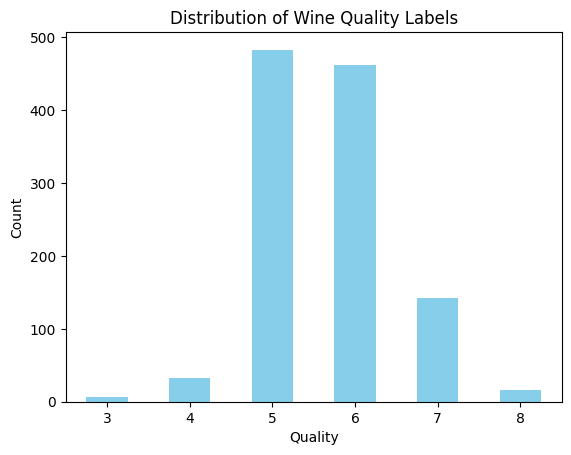

In [42]:
# Plot the distribution of labels
df['quality'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('Distribution of Wine Quality Labels')
plt.xticks(rotation='horizontal')
plt.show()

#### 1.1.3 Dataset Preprocessing

In [43]:
X = df.drop(columns=['quality'])  # Features
y = df['quality']  # Labels

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')  # You can choose 'mean', 'median', or 'most_frequent'
X = imputer.fit_transform(X)

# Normalize the data using MinMaxScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# one hot encode y
y = np.eye(np.unique(y).shape[0])[y]

#### 1.1.4 Splitting the dataset

In [44]:
# Split the data into training, validation, and test sets
# 70% for training, 15% for validation, and 15% for testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Task 1.2 Model Building

#### 1.2.1 Multinomial Logistic regression model

In [72]:
class MultinomialLogisticRegression:
  def __init__(self, learning_rate=0.01, epochs=10000):
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.losses = []
    self.accuracies = []

  def _softmax(self, X):
    exp_X = np.exp(X - np.max(X, axis=1, keepdims=True))
    return exp_X / np.sum(exp_X, axis=1, keepdims=True)

  def _cross_entropy_loss(self, y_true, y_pred):
    # epsilon = 1e-15
    # y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    N = len(y_true)
    loss = -np.sum(y_true * np.log(y_pred)) / N
    return loss

  def train(self, X_train, y_train, X_val, y_val):
    num_samples, num_features = X_train.shape
    num_classes = len(y_train[0])
    self.weights = np.random.rand(num_classes, num_features)

    for epoch in range(self.epochs):
      scores = np.dot(X_train, self.weights.T)
      probabilities = self._softmax(scores)

      # Compute cross-entropy loss on training set
      loss = self._cross_entropy_loss(y_train, probabilities)
      self.losses.append(loss)

      # Compute accuracy on training set
      y_pred_train = label_encoder.inverse_transform(np.argmax(probabilities, axis=1))
      accuracy_train = np.mean(y_pred_train == label_encoder.inverse_transform(np.argmax(y_train, axis = 1)))
      self.accuracies.append(accuracy_train)

      # Compute probabilities on validation set
      scores_val = np.dot(X_val, self.weights.T)
      probabilities_val = self._softmax(scores_val)
      y_pred_val = label_encoder.inverse_transform(np.argmax(probabilities_val, axis=1))

      # Compute accuracy on validation set
      accuracy_val = np.mean(y_pred_val == label_encoder.inverse_transform(np.argmax(y_val, axis = 1)))

      # Print metrics for this epoch
      if epoch == 999:
        print(f"Epoch {epoch + 1}/{self.epochs} - Loss: {loss:.4f} - Accuracy (Train): {accuracy_train:.4f} - Accuracy (Validation): {accuracy_val:.4f}")

      # Update weights using gradient descent
      error = probabilities - y_train
      gradient = np.dot(X_train.T, error) / num_samples
      self.weights -= self.learning_rate * gradient.T
      
    print("Training complete!")
    # print loss and accuracy on train data set
    print("\nLoss and Accuracy on Train Set:")
    y_pred_train = self.predict(X_train)
    print("Loss: ", self._cross_entropy_loss(y_train, y_pred_train))
    y_pred_train = np.argmax(y_pred_train, axis = 1)
    print("Accuracy: ", np.mean(y_pred_train == np.argmax(y_train, axis = 1)))
    print()

    # Print classification report on validation set after training
    self.print_classification_report(X_val, y_val, "Validation")
    return self.losses, self.accuracies
  
  def print_classification_report(self, X, y, name="Validation"):
    print(f"Classification Report on {name} Set:")
    y_pred = np.argmax(self.predict(X), axis = 1)
    print(classification_report(
      label_encoder.inverse_transform(y_pred), 
      label_encoder.inverse_transform(np.argmax(y, axis = 1)),
      zero_division=1
      )
    )

  def predict(self, X):
    scores = np.dot(X, self.weights.T)
    probabilities = self._softmax(scores)
    return probabilities

  def evaluate_accuracy(self, X, y):
    y_pred = np.argmax(self.predict(X), axis = 1)
    accuracy = np.mean(y_pred == np.argmax(y, axis = 1))
    return accuracy

#### 1.2.2 Model training

In [46]:
mlr = MultinomialLogisticRegression(learning_rate=0.01, epochs=1000)
mlr.train(X_train, y_train, X_val, y_val)
print('--' * 50)

Epoch 1000/1000 - Loss: 1.4739 - Accuracy (Train): 0.4913 - Accuracy (Validation): 0.4912
Training complete!

Loss and Accuracy on Train Set:
Loss:  1.4738378513658932
Accuracy:  0.49125


Classification Report on Validation Set:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         9
           4       0.33      0.17      0.22         6
           5       0.81      0.62      0.70        80
           6       0.15      0.67      0.24        18
           7       0.88      0.36      0.51        58
           8       0.00      1.00      0.00         0

    accuracy                           0.49       171
   macro avg       0.53      0.47      0.28       171
weighted avg       0.75      0.49      0.54       171

----------------------------------------------------------------------------------------------------


### Task 1.3 Hyperparameter tuning and Evaluation

#### 1.3.1 Hyperparameter tuning

In [ ]:
import wandb

sweep_config = {
  'method': 'grid',
  'metric': {
    'name': 'composite_metric',
    'goal': 'maximize'
  },
  'parameters': {
    'learning_rates': {'values': [0.001, 0.01, 0.1, 1]},
    'epochs': {'values': [100, 500, 1000, 2000]}
  }
}

sweep_id = wandb.sweep(sweep=sweep_config, project="Multinomial-Logistic-Regression")

# Define sweep function
def sweep_function():
  with wandb.init(config=sweep_config):
    learning_rate = wandb.config.learning_rates
    epochs = wandb.config.epochs
    mlr = MultinomialLogisticRegression(learning_rate=learning_rate, epochs=epochs)
    train_losses, train_accuracies = mlr.train(X_train, y_train, X_val, y_val)
    validation_loss = mlr._cross_entropy_loss(y_val, mlr.predict(X_val))
    validation_accuracy = mlr.evaluate_accuracy(X_val, y_val)
    
    # Log hyperparameters and validation loss
    wandb.log({
      "learning_rate": learning_rate, 
      "epochs": epochs, 
      "validation_loss": validation_loss, 
      "validation_accuracy": validation_accuracy, 
      "composite_metric": validation_accuracy - 0.2 * validation_loss
    })
    epochs = np.arange(1, len(train_losses) + 1)
    
    for i in range(1, len(train_losses) + 1):
      wandb.log({
        "epoch": i,
        "train_loss": train_losses[i-1],
        "train_accuracy": train_accuracies[i-1]
      })
      
wandb.agent(sweep_id, function=sweep_function)

#### wandb logging done

In [65]:
# Initialize W&B API
api = wandb.Api()

best_run = api.sweep("chnaveenin/Multinomial-Logistic-Regression/sweeps/"+sweep_id).best_run()
print('Results for best run:')
print(
  'epochs:', best_run.config['epochs'], '\n'
  'learning_rate:', best_run.config['learning_rates'], '\n'
  'validation_loss:', best_run.summary['validation_loss'], '\n'
  'validation_accuracy:', best_run.summary['validation_accuracy'], '\n'
  'composite_metric:', best_run.summary['composite_metric'],
)

wandb: Sorting runs by -summary_metrics.composite_metric


Results for best run:
epochs: 1000 
learning_rate: 0.1 
validation_loss: 1.5133413349674043 
validation_accuracy: 0.5555555555555556 
composite_metric: -0.20111511192814657


#### 1.3.2 Evaluation

In [73]:
mlr = MultinomialLogisticRegression(learning_rate=best_run.config['learning_rates'], epochs=best_run.config['epochs'])
mlr.train(X_train, y_train, X_val, y_val)
print('--'*50)
print()
print('Accuracy (Test):', mlr.evaluate_accuracy(X_test, y_test))
mlr.print_classification_report(X_test, y_test, "Test")

Epoch 1000/1000 - Loss: 1.3968 - Accuracy (Train): 0.5800 - Accuracy (Validation): 0.5497
Training complete!

Loss and Accuracy on Train Set:
Loss:  1.3968425713674464
Accuracy:  0.58

Classification Report on Validation Set:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         2
           4       0.00      0.00      0.00         5
           5       0.74      0.61      0.67        75
           6       0.40      0.65      0.49        49
           7       0.67      0.42      0.52        38
           8       0.00      0.00      0.00         2

    accuracy                           0.55       171
   macro avg       0.47      0.28      0.28       171
weighted avg       0.60      0.55      0.55       171

----------------------------------------------------------------------------------------------------

Accuracy (Test): 0.5523255813953488
Classification Report on Test Set:
              precision    recall  f1-score   support

   